In [1]:
import torch
from torchvision import models
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
model_path = '../Models'
eval_path = './Training'
data_path='../Dataset/Dataset5K'

model_names = [
    'resnet_5k_best.pth',
    'resnet_pt_5k_best.pth',
    'googlenet_5k_best.pth',
    'googlenet_pt_5k_best.pth',
    'vgg_5k_best.pth',
    'vgg_pt_5k_best.pth'
]

# Train Result
<li><b>resnet_5k_best.pth</b>: ResNet18 with dataset 5K images</li>
<li><b>resnet_pt_5k_best.pth</b>: ResNet18 pre-trained with dataset 5K images</li>
<li><b>googlenet_5k_best.pth</b>: GoogleNet with dataset 5K images</li>
<li><b>googlenet_pt_5k_best.pth</b>: GoogleNet pre-trained with dataset 5K images</li>
<li><b>vgg_5k_best.pth</b>: VGG16 with dataset 5K images</li>
<li><b>vgg_pt_5k_best.pth</b>: VGG16 pre-trained with dataset 5K images</li>

## Training vs Accuracy Result

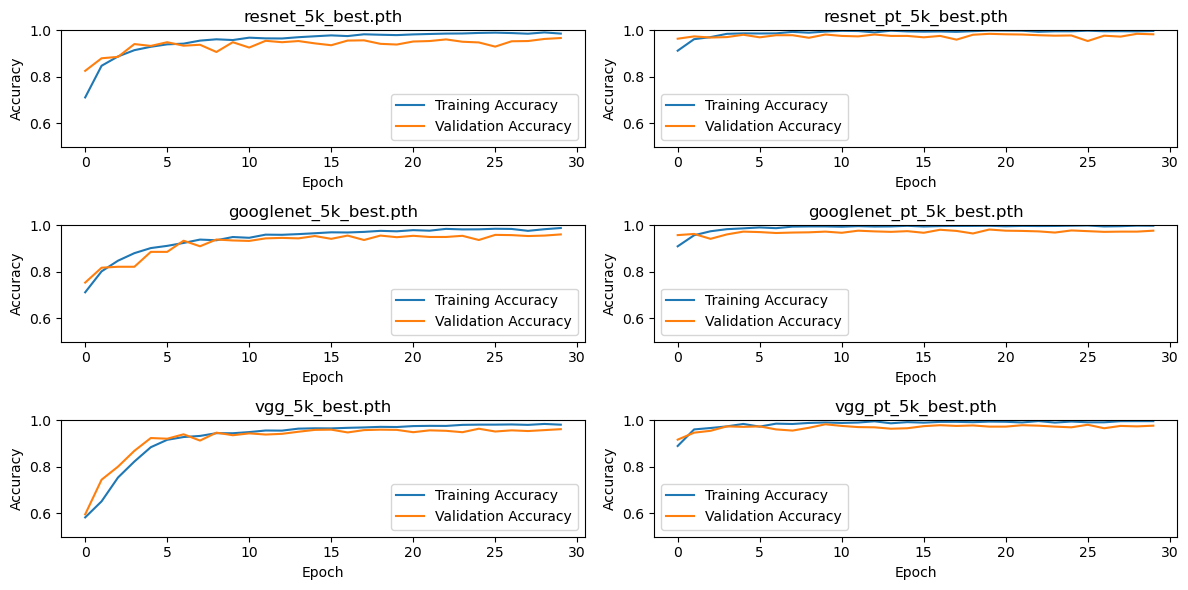

In [3]:
# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 6))
axs = axs.flatten()  # flatten 2x2 grid to list for easy indexing

for idx, model_name in enumerate(model_names):
    model_state_path = os.path.join(model_path, model_name)
    if not os.path.exists(model_state_path):
        raise FileNotFoundError(f"Model not found: {model_state_path}. Please run model training first.")

    model_acc_path = os.path.join(eval_path, model_name + '_train_acc.csv')
    if not os.path.exists(model_acc_path):
        raise FileNotFoundError(f"Training accuracy history not found: {model_acc_path}. Please run model training first.")

    # Load accuracy data
    df_acc = pd.read_csv(model_acc_path)

    # Plot on subplot
    ax = axs[idx]
    ax.plot(df_acc['train'], label='Training Accuracy')
    ax.plot(df_acc['test'], label='Validation Accuracy')
    ax.set_title(model_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.5, 1.0)
    ax.legend()

plt.tight_layout()
plt.show()

## Model Summary

In [4]:
all_summaries = []

for model_name in model_names:
    model_sum_path = os.path.join(eval_path, model_name + '_train_sum.csv')
    if not os.path.exists(model_sum_path):
        raise FileNotFoundError(f"Training summary not found: {model_sum_path}. Please run model training first.")
    
    df_sum = pd.read_csv(model_sum_path)
    
    # Optionally add a column to indicate which model this summary is from
    df_sum['model'] = model_name
    
    all_summaries.append(df_sum)

# Combine all summaries into one DataFrame
df_combined = pd.concat(all_summaries, ignore_index=True)
df_combined['training_time'] = df_combined['time_elapsed'].apply(
    lambda x: f"{int(x // 60)}m {int(x % 60)}s"
)

print(df_combined)


   Unnamed: 0                      mode    device  time_elapsed  best_epoch  \
0           0        resnet_5k_best.pth  Tesla T4    965.127540          29   
1           0     resnet_pt_5k_best.pth  Tesla T4   1061.532705          19   
2           0     googlenet_5k_best.pth  Tesla T4   1044.936090          29   
3           0  googlenet_pt_5k_best.pth  Tesla T4   1105.777221          19   
4           0           vgg_5k_best.pth  Tesla T4   2133.302468          24   
5           0        vgg_pt_5k_best.pth  Tesla T4   2022.231510           9   

   best_acc                     model training_time  
0     0.967        resnet_5k_best.pth        16m 5s  
1     0.985     resnet_pt_5k_best.pth       17m 41s  
2     0.961     googlenet_5k_best.pth       17m 24s  
3     0.982  googlenet_pt_5k_best.pth       18m 25s  
4     0.964           vgg_5k_best.pth       35m 33s  
5     0.983        vgg_pt_5k_best.pth       33m 42s  


# Model Evaluation

In [5]:
def evaluate_model(model, test_loader, class_names, device=None):
    """
    Enhanced evaluation with prediction timing
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test set
        class_names: List of class names (e.g., ["female", "male"])
        device: Device to run evaluation on (auto-detects if None)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    model.eval()
    
    total_samples = 0
    correct = 0
    all_preds = []
    all_labels = []
    total_time = 0.0  # For timing measurement
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Start timer
            start_time = time.time()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # End timer
            batch_time = time.time() - start_time
            total_time += batch_time
            
            total_samples += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = correct / total_samples
    avg_time_per_sample = (total_time / total_samples) * 1000  # Convert to milliseconds
    
    print(f'\nEvaluation Results:')
    print(f'- Accuracy: {accuracy:.4f}')
    print(f'- Total samples: {total_samples}')
    print(f'- Total prediction time: {total_time:.4f} seconds')
    print(f'- Average time per sample: {avg_time_per_sample:.2f} ms')
    
    return {
        'accuracy': accuracy,
        'predictions': all_preds,
        'true_labels': all_labels,
        'total_time': total_time,
        'avg_time_per_sample': avg_time_per_sample
    }

In [ ]:
def plot_confusion_matrix(true_labels, predictions, class_names, normalize=False, title='Confusion Matrix'):
    """
    Plot a confusion matrix using matplotlib/seaborn
    
    Args:
        true_labels: Array of true labels (0=female, 1=male)
        predictions: Array of model predictions
        class_names: List of class names ["female", "male"]
        normalize: Whether to show percentages (True) or counts (False)
        title: Title for the plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    # Create plot
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True)
    
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    # Adjust layout to prevent cutoff
    plt.tight_layout()
    plt.show(

In [73]:
import numpy as np
images_list = os.listdir(data_path + '/Images')

# load the data
data = pd.read_csv(data_path + '/list_attribute.txt', sep='\\s+', skiprows=1)
# filter the data with available images only (5000 images)
filter_index = data.index.intersection(images_list)
data = data.loc[filter_index]['Male'].reset_index().rename(columns={'index':'Filename'})
data['Male'] = np.where(data['Male'] == 1, 1, 0)
data.head()

,Filename,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0


In [ ]:
from sklearn.model_selection import train_test_split
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.shape, test_data.shape

In [ ]:
from torch.utils.data import Dataset, DataLoader

class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        
        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')
        
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [ ]:
from torchvision import transforms

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same as training
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
model = models.googlenet(aux_logits=False, init_weights=False)  # replace with your actual model, e.g., models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
checkpoint = torch.load(os.path.join(model_path, 'googlenet_5k_best.pth'), map_location='cuda')  # or 'cuda' if using GPU
model.load_state_dict(checkpoint['model'])
print('Model GoogleNet')
accuracy, all_preds, all_labels, total_time, avg_time_per_sample = evaluate_model(model,test_loader, ["female", "male"])

In [ ]:
model = models.resnet18()  # replace with your actual model, e.g., models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
checkpoint = torch.load(os.path.join(model_path, 'resnet_5k_best.pth'), map_location='cuda')  # or 'cuda' if using GPU
model.load_state_dict(checkpoint['model'])
print('Model ResNet18')
accuracy, all_preds, all_labels, total_time, avg_time_per_sample = evaluate_model(model,test_loader, ["female", "male"])

In [ ]:
model = models.vgg16()  # replace with your actual model, e.g., models.resnet18()
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)  # for 2 output classes: male/female
checkpoint = torch.load(os.path.join(model_path, 'vgg_5k_best.pth'), map_location='cuda')  # or 'cuda' if using GPU
model.load_state_dict(checkpoint['model'])
print('Model VGG16')
accuracy, all_preds, all_labels, total_time, avg_time_per_sample = evaluate_model(model,test_loader, ["female", "male"])